In [1]:
from tensorflow.keras.datasets.fashion_mnist import load_data

In [2]:
(trainX, trainY), (testX, testY) = load_data()

In [3]:
print("Train", trainX.shape, trainY.shape)
print("Test", testX.shape, testY.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [4]:
import matplotlib.pyplot as plt

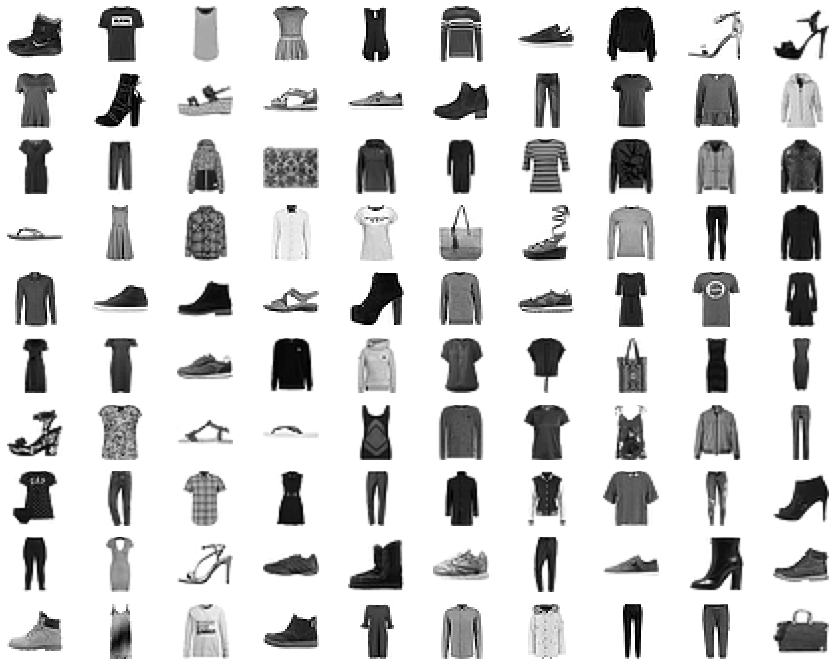

In [5]:
plt.figure(figsize=(15, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [6]:
from numpy import expand_dims

In [7]:
X = expand_dims(trainX, axis=-1)
X = X.astype('float32')
X = (X-127.5)/127.5
print(X.shape)

(60000, 28, 28, 1)


In [8]:
trainY.shape

(60000,)

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Input, Embedding, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam

In [10]:
def define_discriminator(in_shape=(28,28,1), classes=10):
    in_label = Input(shape=(1,))
    li = Embedding(classes, 50)(in_label)
    li = Dense(in_shape[0]*in_shape[1])(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    fe = Conv2D(128, (3,3), strides=(2,2), padding="same")(merge)
    fe = LeakyReLU(0.2)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding="same")(fe)
    fe = LeakyReLU(0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out = Dense(1, activation="sigmoid")(fe)
    model = Model([in_image, in_label], out)
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
#     model.summary()
    return model
#     model = Sequential()
#     model.add(Conv2D(128, (3,3), strides=(2,2), padding="same", input_shape=in_shape))
#     model.add(LeakyReLU(0.2))
#     model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
#     model.add(LeakyReLU(0.2))
#     model.add(Flatten())
#     model.add(Dropout(0.4))
#     model.add(Dense(1, activation="sigmoid"))
    
#     optimizer = Adam(lr=0.0002, beta_1=0.5)
#     model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
#     return model
    

In [11]:
from tensorflow.keras.layers import Conv2DTranspose

In [12]:
def define_generator(classes=10, latent_dim=100):
    in_label = Input(shape=(1,))
    li = Embedding(classes, 50)(in_label)
    li = Dense(7*7)(li)
    li = Reshape((7, 7, 1))(li)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(128*7*7)(in_lat)
    gen = LeakyReLU(0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    merge = Concatenate()([gen, li])
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(merge)
    gen = LeakyReLU(0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(gen)
    gen = LeakyReLU(0.2)(gen)
    out = Conv2D(1, (7,7), activation="tanh", padding="same")(gen)
    model = Model([in_lat, in_label], out)
    return model
    
#     model = Sequential()
#     model.add(Dense(128*7*7, input_dim=latent_dim))
#     model.add(LeakyReLU(0.2))
#     model.add(Reshape((7,7,128)))
#     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
#     model.add(LeakyReLU(0.2))
#     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
#     model.add(LeakyReLU(0.2))
#     model.add(Conv2D(1, (7,7), activation="tanh", padding="same"))
#     return model

In [13]:
def define_gan(generator, discriminator):
    discriminator.trainable=False
    gen_noise, gen_label = generator.input
    gen_output = generator.output
    gan_output = discriminator([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    optimizer=Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy")
    return model
    
#     model = Sequential()
#     model.add(generator)
#     model.add(discriminator)
    
#     optimizer=Adam(lr=0.0002, beta_1=0.5)
#     model.compile(optimizer=optimizer, loss="binary_crossentropy")
#     return model

In [14]:
from numpy import ones, zeros
from numpy.random import randint, randn

In [15]:
def generate_real_samples(n):
    ix = randint(0, X.shape[0], n)
    x, labels = X[ix], trainY[ix]
    y = ones((n, 1))
    return [x, labels], y

In [16]:
def generate_latent_points(n, latent_dim=100, classes=10):
    x = randn(n*latent_dim)
    x = x.reshape((n, latent_dim))
    labels = randint(0, classes, n)
    return [x, labels]

In [17]:
def generate_fake_samples(generator, n, latent_dim=100):
    latent_points, labels = generate_latent_points(n, latent_dim)
    x = generator.predict([latent_points, labels])
    y = zeros((n, 1))
    return [x, labels], y

In [18]:
from IPython.display import clear_output
def plot_samples(generator):
    latent_points, labels = generate_latent_points(100)
    gen = generator.predict([latent_points, labels])
    plt.figure(figsize=(10,10))
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.axis("off")
        plt.imshow(gen[i, :, :, 0], cmap="gray_r")
    clear_output()
    plt.show()

In [19]:
def train(genertor, discriminator, gan, latent_dim=100, epochs=20, batch=128):
    batch_per_epoch = X.shape[0]//batch
    half_batch = batch//2
    plot_samples(generator)
    for i in range(epochs):
        for j in range(batch_per_epoch):
            [X_real, labels_real], y_real = generate_real_samples(half_batch)
            [X_fake, labels_fake], y_fake = generate_fake_samples(generator, half_batch)
            d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
            d_loss2, _ = discriminator.train_on_batch([X_fake, labels_fake], y_fake)
            [X_gan, labels_gan] = generate_latent_points(batch)
            y_gan = ones((batch, 1))
            g_loss = gan.train_on_batch([X_gan, labels_gan], y_gan)
            print("Epoch: %2d, Batch: %3d/%3d, d1=%0.3f, d2=%0.3f, g=%0.3f"%
                  (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
        plot_samples(generator)

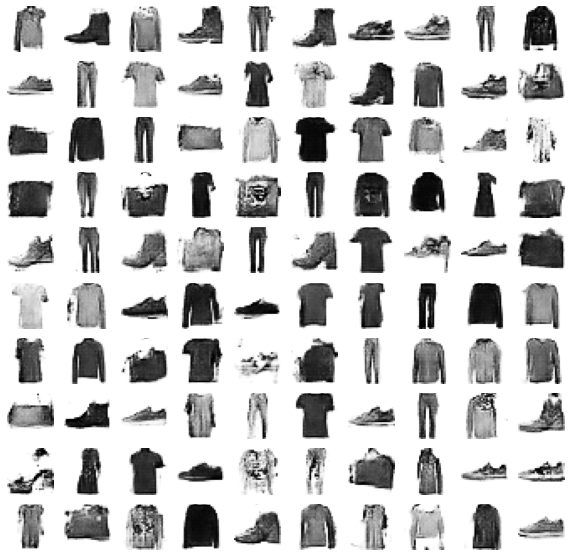

In [20]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan = define_gan(generator, discriminator)
train(generator, discriminator, gan)

In [21]:
generator.save("cgan_generator.h5")